In [5]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from pymongo import MongoClient
import pyodbc
import json
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\maria.rocio.ucha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
# Credenciales para conexión a Azure SQL Server
Server="Driver={SQL Server};Server=tfmcice.database.windows.net;Database=StocksDB;UID=tfmcice;PWD=Q1w2e3r4t5!;Trusted_Connections=no;"

conn = pyodbc.connect(Server)    

cursor = conn.cursor()
cursor.execute('''select s.stock, s.company_name
               from stocks s''') 

row = cursor.fetchone() 
stocks = []
while row: 
    # Columna 0: Ticket, Columna 1: Company Name
    stock_detail = { 'stock' : row[0], 'company_name': row[1]}
    stocks.append(stock_detail)
    row = cursor.fetchone()

cursor.close()
    
print("Total de acciones a recuperar:", len(stocks))
print(stocks)

Total de acciones a recuperar: 11
[{'stock': 'AXP', 'company_name': 'American Express Co'}, {'stock': 'BA', 'company_name': 'Boeing Company'}, {'stock': 'D', 'company_name': 'Dominion Energy'}, {'stock': 'DD', 'company_name': 'DuPont de Nemours Inc'}, {'stock': 'GOOG', 'company_name': 'Alphabet Inc.\xa0(Class C)'}, {'stock': 'IBM', 'company_name': 'International Business Machines'}, {'stock': 'KO', 'company_name': 'Coca-Cola Company'}, {'stock': 'PFE', 'company_name': 'Pfizer Inc.'}, {'stock': 'SPG', 'company_name': 'Simon Property Group Inc'}, {'stock': 'TSLA', 'company_name': 'Tesla, Inc.'}, {'stock': 'XOM', 'company_name': 'Exxon Mobil Corp.'}]


In [3]:
# Connection Mongo DB
uri = "mongodb://tfmcice:i9PqjFS50Iad5WusUksnFnIjleXHo8vXjONtJuSHeDELDrC3nOjMIs6HWIADG7BE1aogkBEFGxzFWTZBgTEEyg==@tfmcice.mongo.cosmos.azure.com:10255/?ssl=true&retrywrites=false&replicaSet=globaldb&maxIdleTimeMS=120000&appName=@tfmcice@"
client = MongoClient(uri)
db = client['StocksDB']
companies = db['Companies']

finwiz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

for company in stocks:
    url = finwiz_url + company.get("stock")
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)

    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[company.get("stock")] = news_table

n = 0
# Iterate through the news
for file_name, news_table in news_tables.items():

    parsed_news = []
    company = stocks[n].get("company_name")
    # Extract the ticker from the file name, get the string up to the 1st '_'
    ticker = file_name.split('_')[0]

    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):

        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 

        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()

        # if the length of 'date_scrape' is 1, load 'time' as the only element
        if len(date_scrape) == 1:
            time = date_scrape[0]

        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0] + " " + date_scrape[1]

        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([company,ticker,date,text])

    n+=1
    
    if len(parsed_news) :
        # Set column names
        columns = ['Company', 'Ticker', 'Date', 'Title']
        # Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
        news_df = pd.DataFrame(parsed_news, columns=columns)

        # Iterate through the headlines and get the polarity scores using vader
        scores = news_df['Title'].apply(vader.polarity_scores).tolist()
        #Convert the 'scores' list of dicts into a DataFrame
        scores_df = pd.DataFrame(scores)

        # Join the DataFrames of the news and the list of dicts
        news_df = news_df.join(scores_df, rsuffix='_right')

        #path = "data/{}_Ticker.xlsx".format(company)
        #news_df.to_excel(path,index=False)

        list_dict = []
        #with open('data/Companies.json', 'a+', encoding='utf-8') as fich:
        for index, row in list(news_df.iterrows()):
            list_dict.append(dict(row))

        companies.insert_many(list_dict)
        #json.dump(list_dict, fich, ensure_ascii=False, indent=4) # , sort_keys=False

client.close()

In [30]:
# Convert the date column from string to datetime
#parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

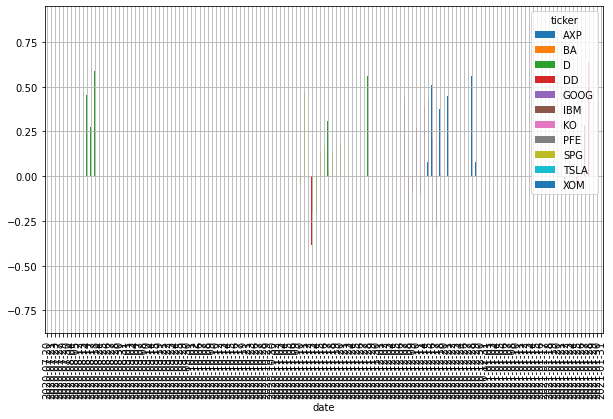

In [31]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()